<a href="https://colab.research.google.com/github/ABHILASH-T6236/BookMate-Book-Recommendation-System/blob/main/BookMate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Books data
file_path = ('/content/drive/MyDrive/Copy of Books.csv')
books = pd.read_csv('/content/Books.csv')
file_path = ('/content/drive/MyDrive/Copy of Users.csv')
users = pd.read_csv('/content/Users.csv')
file_path = ('/content/drive/MyDrive/Copy of Ratings.csv')
ratings = pd.read_csv('/content/Ratings.csv')
# Preview datasets
print("Users Data:")
print(users.head())
print("\nBooks Data:")
print(books.head())
print("\nRatings Data:")
print(ratings.head())



<ipython-input-6-b47e68734a11>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv')


Users Data:
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

Books Data:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este

In [ ]:
# Check for missing values
print("\nMissing Values:")
print("Users: ", users.isnull().sum())
print("Books: ", books.isnull().sum())
print("Ratings: ", ratings.isnull().sum())

# Data Cleaning
users['Age'].fillna(users['Age'].mean(), inplace=True)
ratings = ratings[ratings['Book-Rating'] > 0]  # Removing implicit ratings (Book-Rating = 0)

# Merge datasets for analysis
ratings_with_books = pd.merge(ratings, books, on='ISBN')
complete_data = pd.merge(ratings_with_books, users, on='User-ID')



Missing Values:
Users:  User-ID          0
Location         0
Age         110762
dtype: int64
Books:  ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Ratings:  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


<ipython-input-7-ad64679bf063>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].mean(), inplace=True)



Unique Users:  68091
Unique Books:  135567
Rating Distribution:


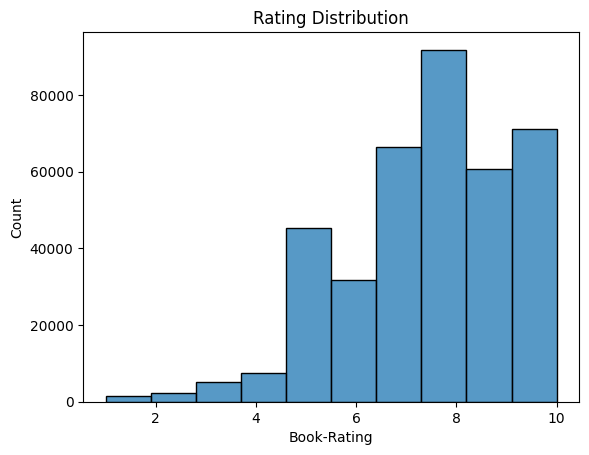

In [ ]:
# Unique counts
print("\nUnique Users: ", complete_data['User-ID'].nunique())
print("Unique Books: ", complete_data['Book-Title'].nunique())

# Rating distribution visualization
print("Rating Distribution:")
sns.histplot(complete_data['Book-Rating'], bins=10, kde=False)
plt.title("Rating Distribution")
plt.show()



Most Popular Books:
                                              Book-Title  Book-Rating
110229                         The Lovely Bones: A Novel          707
132241                                       Wild Animus          581
102703                                 The Da Vinci Code          494
116196                           The Secret Life of Bees          406
111950                        The Nanny Diaries: A Novel          393
114960               The Red Tent (Bestselling Backlist)          383
15761                              Bridget Jones's Diary          377
3064                                     A Painted House          366
60688                                         Life of Pi          336
45374   Harry Potter and the Chamber of Secrets (Book 2)          326


<ipython-input-9-dd6ac96bbc55>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=popularity_data, x='Book-Rating', y='Book-Title', palette='viridis')


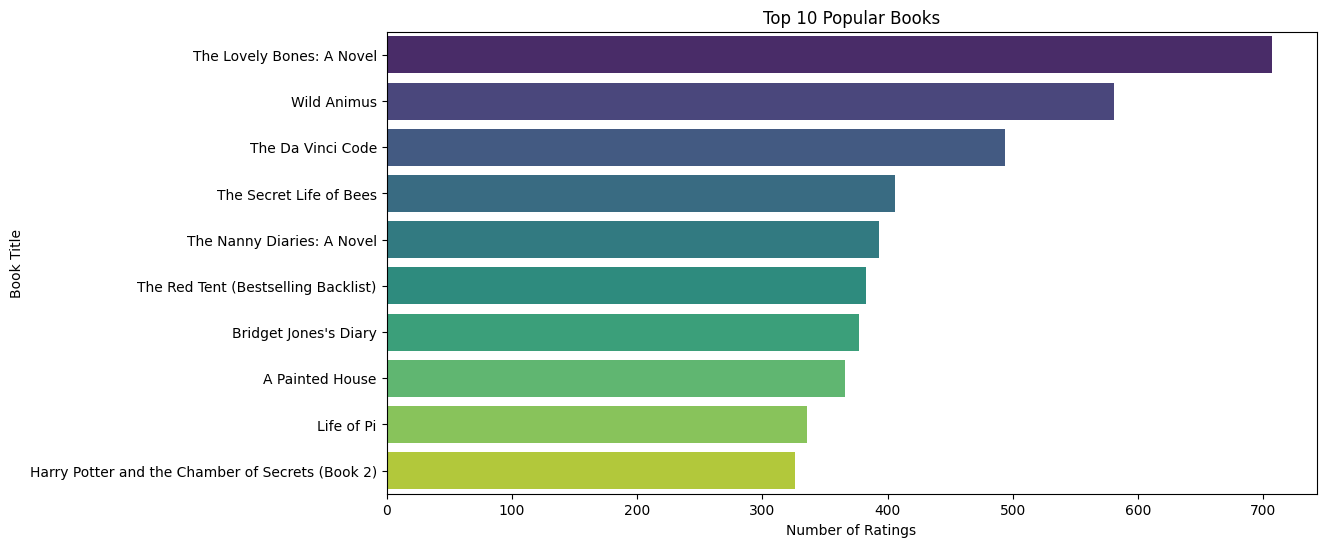

In [ ]:
# Popularity-Based Recommendation
popularity_data = complete_data.groupby('Book-Title').agg({'Book-Rating': 'count'}).reset_index()
popularity_data = popularity_data.sort_values('Book-Rating', ascending=False).head(10)
print("\nMost Popular Books:")
print(popularity_data)

# Plot popular books
plt.figure(figsize=(12, 6))
sns.barplot(data=popularity_data, x='Book-Rating', y='Book-Title', palette='viridis')
plt.title("Top 10 Popular Books")
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.show()


In [ ]:
# Filter the dataset to reduce size
# Keep users with at least 50 ratings and books with at least 50 ratings
filtered_data = complete_data.groupby('User-ID').filter(lambda x: len(x) >= 50)
filtered_data = filtered_data.groupby('Book-Title').filter(lambda x: len(x) >= 50)

# Create a pivot table (user-book matrix)
user_book_matrix = filtered_data.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)

# Convert the pivot table to a sparse matrix to save memory
from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(user_book_matrix)

# Compute cosine similarity on sparse matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(sparse_matrix)

# Convert the similarity matrix to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=user_book_matrix.index, columns=user_book_matrix.index)

# Function to get book recommendations based on similar users
def get_user_recommendations(user_id, num_recommendations=5):
    if user_id not in similarity_df.index:
        print(f"User {user_id} not found in the filtered dataset.")
        return []

    similar_users = similarity_df[user_id].sort_values(ascending=False).index[1:num_recommendations + 1]
    recommended_books = []
    for sim_user in similar_users:
        books_rated = filtered_data[filtered_data['User-ID'] == sim_user]['Book-Title'].unique()
        recommended_books.extend(books_rated)
    return set(recommended_books)

# Example recommendations for a user
print("\nRecommendations for User 275970:")
print(get_user_recommendations(275970))



Recommendations for User 275970:
{"Harry Potter and the Sorcerer's Stone (Book 1)", 'Harry Potter and the Goblet of Fire (Book 4)', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Me Talk Pretty One Day', 'The Partner', 'Harry Potter and the Prisoner of Azkaban (Book 3)'}


In [ ]:
# Filter users who have rated at least 50 books
users_with_50_ratings = complete_data.groupby('User-ID').filter(lambda x: len(x) >= 50)

# Get the unique User-IDs from the filtered dataset
user_ids_in_range = users_with_50_ratings['User-ID'].unique()

# Display the User-IDs
print(f"Total Users with at least 50 ratings: {len(user_ids_in_range)}")
print("User-IDs:")
print(user_ids_in_range)


Total Users with at least 50 ratings: 1180
User-IDs:
[277427 278137 278188 ... 274301 275970 276680]


In [ ]:
import pandas as pd

# Load the Ratings dataset
ratings_df = pd.read_csv('Ratings.csv')

# Count the number of ratings per user
user_rating_counts = ratings_df['User-ID'].value_counts()

# Filter users who have given at least 50 ratings
users_with_50_ratings = user_rating_counts[user_rating_counts >= 50].index.tolist()

# Total number of users who meet the condition
total_users = len(users_with_50_ratings)

# Display the results
print(f"Total Users with at least 50 ratings: {total_users}")
print("User-IDs:")
print(users_with_50_ratings)  # This will show the complete list of User-IDs


Total Users with at least 50 ratings: 3427
User-IDs:
[11676, 198711, 153662, 98391, 35859, 212898, 278418, 76352, 110973, 235105, 230522, 16795, 234623, 36836, 52584, 245963, 204864, 55492, 185233, 171118, 102967, 232131, 227447, 98741, 129358, 60244, 190925, 135149, 231210, 189835, 189334, 69697, 78783, 177458, 172742, 73394, 242824, 269566, 213350, 23768, 238781, 175003, 226545, 36606, 182085, 11601, 148744, 123981, 26544, 43246, 200674, 23902, 274308, 257204, 95359, 166123, 127233, 127429, 162639, 275970, 87141, 172030, 12538, 184299, 238120, 130474, 76626, 236283, 115120, 266226, 93047, 142524, 87555, 254465, 245827, 166596, 196077, 51883, 35050, 265115, 56959, 110029, 228998, 31315, 246655, 271284, 225087, 131402, 56447, 175886, 88733, 40943, 174304, 56399, 251613, 234828, 16634, 158295, 52614, 31556, 156150, 248718, 225810, 35857, 63714, 107784, 167800, 114414, 147847, 274061, 76499, 113519, 182987, 7346, 100906, 224349, 224764, 129074, 252695, 197659, 211426, 265313, 187145, 568

In [ ]:
# Load data into Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Build and train SVD model
svd = SVD()
svd.fit(trainset)

# Evaluate model
predictions = svd.test(testset)
print("\nRMSE of SVD Model:")
print(accuracy.rmse(predictions))

# Function to predict ratings for a user
def predict_rating(user_id, isbn):
    return svd.predict(user_id, isbn).est

# Example prediction
print("\nPredicted Rating for User 276725 and ISBN 034545104X:")
print(predict_rating(276725, '034545104X'))



RMSE of SVD Model:
RMSE: 1.6386
1.6386284984061206

Predicted Rating for User 276725 and ISBN 034545104X:
6.655636973639881


In [ ]:
# Prompt the user for a specific User-ID
specific_user = int(input("Enter the User-ID to check: "))

if specific_user in user_ids_in_range:
    print(f"User {specific_user} is in the range with at least 50 ratings.")
    print("Recommendations for this user:")
    print(get_user_recommendations(specific_user))
else:
    print(f"User {specific_user} is NOT in the range.")


Enter the User-ID to check: 35859
User 35859 is in the range with at least 50 ratings.
Recommendations for this user:
{'1st to Die: A Novel', 'Pet Sematary', 'Dolores Claiborne', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Fahrenheit 451', 'Hannibal', 'The Client', "Where the Heart Is (Oprah's Book Club (Paperback))", 'The Runaway Jury', 'Good in Bed', 'When the Wind Blows', 'The Lovely Bones: A Novel', 'The Fellowship of the Ring (The Lord of the Rings, Part 1)', '2nd Chance', 'The Five People You Meet in Heaven', "The Pilot's Wife : A Novel", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'The Da Vinci Code', 'Life of Pi', 'Summer Sisters', 'The Notebook', 'Insomnia', 'The Summons', 'The Red Tent (Bestselling Backlist)', "Bridget Jones's Diary", 'The Catcher in the Rye', 'The Pelican Brief', 'The Nanny Diaries: A Novel', 'The Secret Life of Bees', 'The Joy Luck Club', 'House of Sand and Fog', 'The Rainmaker', 'Misery'}


In [ ]:
# y_true is the actual ratings given by users
y_true = ratings['Book-Rating'].values  # Extract the ratings

# Optionally, you can filter to consider only positive ratings (if needed)
y_true = [1 if rating >= 6 else 0 for rating in y_true]  # Rating >=6 is considered liked (1), otherwise disliked (0)

In [ ]:
# For example, let's predict ratings based on the popularity of the books (simple baseline model)
# Popularity-based approach: Predict a "liked" recommendation if the book is rated more than average

# Calculate the average rating for each book (you could use this as a basic predictor)
# Use the 'ratings' DataFrame instead of 'ratings_df'
book_avg_ratings = ratings.groupby('ISBN')['Book-Rating'].mean()

# For simplicity, predict that a book is "liked" (1) if its average rating is >=6
# Use the 'ratings' DataFrame instead of 'ratings_df'
y_pred = ratings['ISBN'].apply(lambda x: 1 if book_avg_ratings[x] >= 6 else 0)

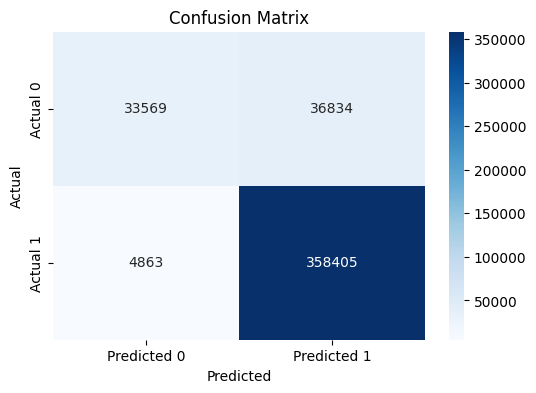

Accuracy: 0.90
Precision: 0.91
Recall: 0.99
F1 Score: 0.95


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
